## 2.3 Combination Matrix over undirected network

### 2.3.1 Weight

We now associate each edge with a positive weight. This weight is used to scale information following over the associated edge.

For a given topology, we define $w_{ij}$, the weight to scale information flowing from agent $j$ to agent $i$, as follows:

\begin{align}\label{wij}
w_{ij}
\begin{cases}
> 0 & \mbox{if $(j,i) \in \mathcal{E}$, or $i=j$;} \\
= 0 & \mbox{otherwise.} 
\end{cases}
\end{align}

### 2.3.2 Combination matrix and a fundamental assumption

We further define the combination matrix $W = [w_{ij}]_{i,j=1}^{n} \in \mathbb{R}^{n\times n}$ to stack all weights into a matrix. Such matrix $W$ will characterize the sparsity and connectivity of the underlying network topology. Throughout this section, we assume the combination matrix $W$ satisfies the following important assumption.

> **Assumption 1 (Doubly stochastic)** We assume $W$ is a doubly stochastic matrix, i.e., 
$W \mathbf{1} = \mathbf{1}$ and $\mathbf{1}^T W = \mathbf{1}^T$.

The above assumption essentially implies that both the row sum and the column sum of matrix $W$ are $1$, i.e., $\sum_{j=1}^n w_{ij} = 1$ and $\sum_{i=1}^n w_{ij} = 1$. This assumption indicates that each agent is taking a wighted local average in this neighborhood, and it is fundamental to guarantee that average consensus will converge to the global average $\bar{x}$ asymtotically.

### 2.3.3 Combination matrix over the undirected network

In a undirected network, the edges $(i,j)$ and $(j,i)$ will appear in a pari-wise manner. Undirected network is very common in nature. In a [random geometric graph](https://networkx.org/documentation/stable/auto_examples/drawing/plot_random_geometric_graph.html), two agents $i$ and $j$ within a certain distance are regarded neighbors. Apparently, both edges $(i,j)$ and $(j,i)$ exist for this scenario. Given a undirected network topology, there are many rules that can help generate combination matrix satisfying Assumption 1. The most well-known rule is the Metropolis-Hastings rule \[Refs\]:

> **Metropolis-Hastings rule.** Providing a undirected and connected topology $\mathcal{G}$, we select $w_{ij}$ as
> 
>\begin{align}
\hspace{-3mm}	w_{ij}=
	\begin{cases}
		\begin{array}{ll}\displaystyle
			\hspace{-2mm}\frac{1}{1 + \max\{d_i, d_j \}},& \mbox{if $j \in \mathcal{N}(i)$}, \\
			\hspace{-2mm}\displaystyle 1 - \sum_{j\in \mathcal{N}(i)}w_{ij}, & \mbox{if $i = j$},\\
			\hspace{-2mm}0,& \mbox{if $j \notin \mathcal{N}(i)$  and $j\neq i$}.
		\end{array}
	\end{cases}
\end{align}
>
> where $d_i = |\mathcal{N}(i)|$ (the number of incoming neighbors of agent $k$). It is easy to verify such $W$ is always doubly-stochastic.

The other popular approaches can be found in Table 14.1 of reference \[Refs\].

#### 2.3.3.1 Example I: Commonly-used topology and associated combination matrix

In BlueFog, we support various commonly-used undirected topologies such as ring, star, 2D-mesh, fully-connected graph, hierarchical graph, etc. One can organize his clusters into any of these topopology easily with the function ```bluefog.common.topology_util```, see the deatil in the [user manual](https://bluefog-lib.github.io/bluefog/topo_api.html?highlight=topology#module-bluefog.common.topology_util). In addition, BlueFog also provides the associated combination matrix for these topologies. These matrices are guaranteed to be symmetric and doubly stochas

**Note:** The reader not familiar with how to run BlueFog in ipython notebook environment is encouraged to read Sec. \[HelloWorld section\] first.

- **A: Test whether BlueFog works normally (the same steps as illustrated in Sec. 2.1)**

In the following code, you should be able to see the id of your CPUs. We use 8 CPUs to conduct the following experiment.

In [1]:
import numpy as np
import bluefog.torch as bf
import torch
import networkx as nx   # nx will be used for network topology creating and plotting
from bluefog.common import topology_util
import matplotlib.pyplot as plt
%matplotlib inline
import ipyparallel as ipp

np.set_printoptions(precision=3, suppress=True, linewidth=200)

rc = ipp.Client(profile='bluefog')
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

Let each agent import necessary modules and then initialize BlueFog. You should be able to see the printed information like:  

> \[stdout:0\] Hello, I am 1 among 8 processes
> 
> ...

In [2]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx

bf.init()
print(f"Hello, I am {bf.rank()} among {bf.size()} processes")

[stdout:0] Hello, I am 0 among 8 processes
[stdout:1] Hello, I am 6 among 8 processes
[stdout:2] Hello, I am 1 among 8 processes
[stdout:3] Hello, I am 4 among 8 processes
[stdout:4] Hello, I am 3 among 8 processes
[stdout:5] Hello, I am 7 among 8 processes
[stdout:6] Hello, I am 5 among 8 processes
[stdout:7] Hello, I am 2 among 8 processes


Push seed to each agent so that the simulation can be reproduced.

In [3]:
dview = rc[:] # A DirectView of all engines
dview.block=True

# Push the data into all workers
dview.push({'seed': 2021}, block=True)

[None, None, None, None, None, None, None, None]

After running the following code, you should be able to see the printed information like 

> \[stdout:0\] I received seed as value:  2021
> 
> ...

In [4]:
%%px
print("I received seed as value: ", seed)

[stdout:0] I received seed as value:  2021
[stdout:1] I received seed as value:  2021
[stdout:2] I received seed as value:  2021
[stdout:3] I received seed as value:  2021
[stdout:4] I received seed as value:  2021
[stdout:5] I received seed as value:  2021
[stdout:6] I received seed as value:  2021
[stdout:7] I received seed as value:  2021


Congratulations! Your BlueFog is initialized and tested successfully.

- **B: Undirected Ring topology and associated combination matrix**

We now construct a ring topology. Note that to plot the topology, we have to pull the topology information from the agent to the Jupyter engine. That is why we have to use ```dview.pull```. In the following code, ```bf.size()``` will return the size of the network.

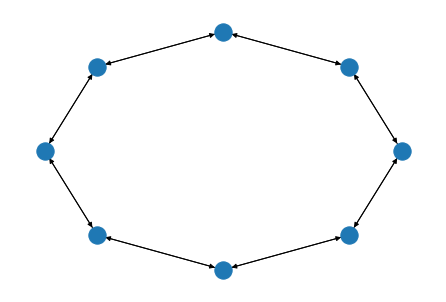

In [5]:
# Generate topology.

# Plot figure
%px G = topology_util.RingGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

When the topology is generated through BlueFog utilities (such as ```RingGraph()```, ```ExponentialTwoGraph()```, ```MeshGrid2DGraph()``` and others in the [user manual](https://bluefog-lib.github.io/bluefog/topo_api.html?highlight=topology#module-bluefog.common.topology_util)), the associated combination matrix is provided automatically. 
Now we examine the self weight and neighbor weights of each agent in the ring topology. To this end, we can use ```GetRecvWeights()``` to get these information. In the following code, ```bf.rank()``` will return the label of that agent. Note that all agents will run the following code in parallel (One can see that from the magic command ```%%px```). 

In [6]:
%%px

self_weight, neighbor_weights = topology_util.GetRecvWeights(G, bf.rank())

Now we examine the self weight and neighbor weights of agent $0$.

In [7]:
%%px
if bf.rank() == 0:
    print('self weights: {}\n'.format(self_weight))
    print('neighbor weights:')
    for k, v in neighbor_weights.items():
        print('neighbor id:{}, weight:{}'.format(k, v))

[stdout:0] 
self weights: 0.3333333333333333

neighbor weights:
neighbor id:1, weight:0.3333333333333333
neighbor id:7, weight:0.3333333333333333


We can even construct the combination matrix $W$ and examine its property. To this end, we will pull the weights of each agent into the Jupyter engine and then construct the combination matrix. The method to pull information from agent is 

```dview.pull(information_to_pull, targets=agent_idx)```

It should be noted that ```agent_idx``` is not the rank of each agent. Instead, it is essentially the order that the engine collects information from each agent. We need to establish a mapping between rank and agent_idx.

In [8]:
network_size = dview.pull('bf.size()', block=True, targets=0)
agentID_to_rank = {}
for idx in range(network_size):
    agentID_to_rank[idx] = dview.pull('bf.rank()', block=True, targets=idx)
    
for k,v in agentID_to_rank.items():
    print('id:{}, rank:{}'.format(k, v))

id:0, rank:0
id:1, rank:6
id:2, rank:1
id:3, rank:4
id:4, rank:3
id:5, rank:7
id:6, rank:5
id:7, rank:2


Now we construct the combination matrix $W$.

In [9]:
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.333 0.333 0.    0.    0.    0.    0.    0.333]
 [0.333 0.333 0.333 0.    0.    0.    0.    0.   ]
 [0.    0.333 0.333 0.333 0.    0.    0.    0.   ]
 [0.    0.    0.333 0.333 0.333 0.    0.    0.   ]
 [0.    0.    0.    0.333 0.333 0.333 0.    0.   ]
 [0.    0.    0.    0.    0.333 0.333 0.333 0.   ]
 [0.    0.    0.    0.    0.    0.333 0.333 0.333]
 [0.333 0.    0.    0.    0.    0.    0.333 0.333]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


- **I-C: Undirected Star topology and associated combination matrix**

We can follow the above codes to draw the star topology and its associated combination matrix

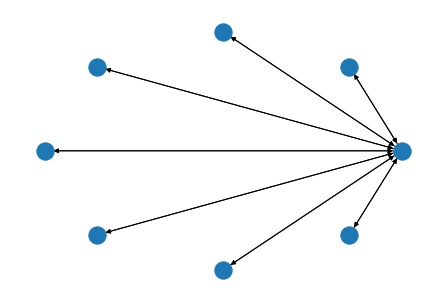

In [10]:
# Generate topology.

# Plot figure
%px G = topology_util.StarGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [11]:
%%px

self_weight, neighbor_weights = topology_util.GetRecvWeights(G, bf.rank())

In [12]:
network_size = dview.pull('bf.size()', block=True, targets=0)
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.875 0.    0.    0.    0.    0.    0.   ]
 [0.125 0.    0.875 0.    0.    0.    0.    0.   ]
 [0.125 0.    0.    0.875 0.    0.    0.    0.   ]
 [0.125 0.    0.    0.    0.875 0.    0.    0.   ]
 [0.125 0.    0.    0.    0.    0.875 0.    0.   ]
 [0.125 0.    0.    0.    0.    0.    0.875 0.   ]
 [0.125 0.    0.    0.    0.    0.    0.    0.875]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


- **I-D: Undirected 2D-Mesh topology and associated combination matrix**

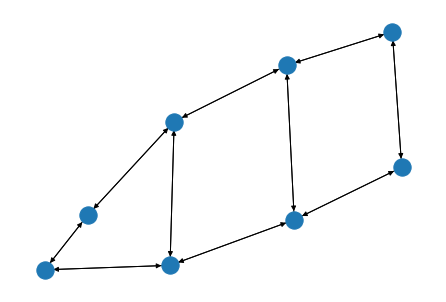

In [13]:
# Generate topology.

# Plot figure
%px G = topology_util.MeshGrid2DGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_spring(G_0)

In [14]:
%%px

self_weight, neighbor_weights = topology_util.GetRecvWeights(G, bf.rank())

In [15]:
network_size = dview.pull('bf.size()', block=True, targets=0)
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.417 0.25  0.    0.    0.333 0.    0.    0.   ]
 [0.25  0.25  0.25  0.    0.    0.25  0.    0.   ]
 [0.    0.25  0.25  0.25  0.    0.    0.25  0.   ]
 [0.    0.    0.25  0.417 0.    0.    0.    0.333]
 [0.333 0.    0.    0.    0.417 0.25  0.    0.   ]
 [0.    0.25  0.    0.    0.25  0.25  0.25  0.   ]
 [0.    0.    0.25  0.    0.    0.25  0.25  0.25 ]
 [0.    0.    0.    0.333 0.    0.    0.25  0.417]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


- **I-E: Undirected 2D-Mesh topology and associated combination matrix**

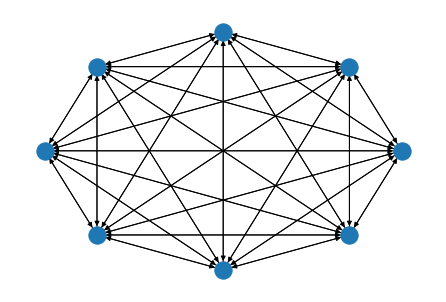

In [16]:
# Generate topology.

# Plot figure
%px G = topology_util.FullyConnectedGraph(bf.size())

G_0 = dview.pull('G', block=True, targets=0)
nx.draw_circular(G_0)

In [17]:
%%px

self_weight, neighbor_weights = topology_util.GetRecvWeights(G, bf.rank())

In [18]:
network_size = dview.pull('bf.size()', block=True, targets=0)
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


The readers are encourged to test other topologies and examine their associated combination matrix. Check the topology related utility function in [user manual](https://bluefog-lib.github.io/bluefog/topo_api.html?highlight=topology#module-bluefog.common.topology_util).

#### 2.3.3.2 Example II: Set up your own topology

There also exist scenarios in which you want to organize the agents into your own magic topologies. In this example, we will show how to produce the combination matrix via the Metropolis-Hastings rule and generate the network topology that can be imported to BlueFog utilities.

Before we generate the combination matrix, you have to prepare an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix) of your topology. Since the topology is undirected, the adjacency matrix should be symmetric.

In [19]:
def gen_comb_matrix_via_MH(A):
    
    '''
    Input:  adjacency matirx A: numpy 2D array with dims (n,n)
    Output: combination matrix W: numpy 2D array with dims (n,n)
    '''
    
    # the adjacency matrix must be symmetric
    assert np.linalg.norm(A - A.T) < 1e-6
    
    # make sure the diagonal elements of A are 0
    n, _ = A.shape
    for i in range(n):
        A[i,i] = 0
        
    # compute the degree of each agent
    d = np.sum(A, axis=1)
    
    # identify the neighbor of each agent
    neighbors = {}
    for i in range(n):
        neighbors[i] = set()
        for j in range(n):
            if A[i,j] == 1:
                neighbors[i].add(j)
                
    # generate W via M-H rule
    W = np.zeros((n,n))
    for i in range(n):
        for j in neighbors[i]:
            W[i,j] = 1/(1+np.maximum(d[i], d[j]))
            
    W_row_sum = np.sum(W,axis=1)
    for i in range(n):
        W[i,i] = 1 - W_row_sum[i]
    
    return W

Random geometric graph is one of the undirected graph that nutrally appears in many application. It is constructed by randomly placing $n$ nodes in some metric space (according to a specified probability distribution) and connecting two nodes by a link if and only if their distance is in a given range $r$.

Random geometric graph is not provided in BlueFog. In the following codes, we will show how to generate the combination matrix of random geometric graph via Metropolis-Hastings rule, and how to import the topology, and the combination matrix into BlueFog to facilitate the downstream average consensus and decentralized optimization algorithms.

test the correctedness of the above function. To this end, we define a new network topology: we randomly generate the 2D coordinates of $n$ agents within a $1 \times 1$ square. If the distance between two nodes are within $r$, they are regarded as neighbors. We call such network topology as distance-decided network. 

The following functioin will return the adjacency matrix of the random geometric graph.

In [20]:
def gen_random_geometric_topology(num_agents, r):
    
    '''
    num_agents: the number of agents in the network
    r: two agents within the distance 'r' are regarded as neighbors
    '''
    
    # Generate n random 2D coordinates within a 1*1 square
    agents = {}
    for i in range(num_agents):
        agents[i] = np.random.rand(2,1)
        
    A = np.zeros((num_agents, num_agents))
    for i in range(num_agents):
        for j in range(i+1, num_agents):
            dist = np.linalg.norm(agents[i] - agents[j])
            if dist < r:
                A[i,j] = 1
                A[j,i] = 1
                
    return A

Now we use the above utility function to generate a random distance-decided network. One can adjust parameter ```r``` to manipulate the density of the network topology.

The adjacency matrix of the generated network is:
[[0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0.]]


The associated combination matrix is:
[[0.3  0.   0.   0.2  0.25 0.   0.25 0.  ]
 [0.   0.3  0.   0.2  0.   0.25 0.   0.25]
 [0.   0.   0.75 0.   0.   0.   0.25 0.  ]
 [0.2  0.2  0.   0.2  0.2  0.   0.   0.2 ]
 [0.25 0.   0.   0.2  0.3  0.   0.25 0.  ]
 [0.   0.25 0.   0.   0.   0.75 0.   0.  ]
 [0.25 0.   0.25 0.   0.25 0.   0.25 0.  ]
 [0.   0.25 0.   0.2  0.   0.   0.   0.55]]


W is symmetric.
W is doubly stochastic.


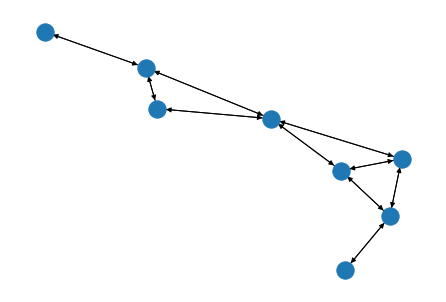

In [21]:
np.random.seed(seed=2021)

num_nodes = len(rc.ids)
A = gen_random_geometric_topology(num_agents=num_nodes, r=0.5)
print('The adjacency matrix of the generated network is:')
print(A)

print('\n')
print('The associated combination matrix is:')
W = gen_comb_matrix_via_MH(A)
print(W)

# test whether it is symmetric and doubly stochastic
print('\n')
if np.linalg.norm(W-W.T) == 0:
    print('W is symmetric.')
    
if np.sum(W,axis=0).all() == 1 and np.sum(W,axis=1).all() == 1:
    print('W is doubly stochastic.')
    
# generate topology from W
G = nx.from_numpy_array(W, create_using=nx.DiGraph)

# draw topology
nx.draw_spring(G)

Given $W$ generated from the M-H rule, next we organize the agents into the above topology with ```set_topology(G)```. We further examine whether the agents' associated combination matrix is consistent with the above generated ombination matrix $W$. 

In [22]:
dview.push({'W': W}, block=True)

[None, None, None, None, None, None, None, None]

In [23]:
%%px

G = nx.from_numpy_array(W, create_using=nx.DiGraph)
bf.set_topology(G)
topology = bf.load_topology()
self_weight, neighbor_weights = topology_util.GetRecvWeights(topology, bf.rank())

In [24]:
network_size = dview.pull('bf.size()', block=True, targets=0)
W = np.zeros((network_size, network_size))

for idx in range(network_size):
    self_weight = dview.pull('self_weight', block=True, targets=idx)
    neighbor_weights = dview.pull('neighbor_weights', block=True, targets=idx)
    
    W[agentID_to_rank[idx],agentID_to_rank[idx]] = self_weight
    for k, v in neighbor_weights.items():
        W[agentID_to_rank[idx],k] = v

print('The matrix W is:')
print(W)

# check the row sum and column sum
print('\nRow sum of W is:', np.sum(W, axis=1))
print('Col sum of W is:', np.sum(W, axis=0))

if np.sum(W, axis=1).all() and np.sum(W, axis=0).all():
    print('The above W is doubly stochastic.')

The matrix W is:
[[0.3  0.   0.   0.2  0.25 0.   0.25 0.  ]
 [0.   0.3  0.   0.2  0.   0.25 0.   0.25]
 [0.   0.   0.75 0.   0.   0.   0.25 0.  ]
 [0.2  0.2  0.   0.2  0.2  0.   0.   0.2 ]
 [0.25 0.   0.   0.2  0.3  0.   0.25 0.  ]
 [0.   0.25 0.   0.   0.   0.75 0.   0.  ]
 [0.25 0.   0.25 0.   0.25 0.   0.25 0.  ]
 [0.   0.25 0.   0.2  0.   0.   0.   0.55]]

Row sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
Col sum of W is: [1. 1. 1. 1. 1. 1. 1. 1.]
The above W is doubly stochastic.


It is observed that the agents' associated combination matrix is consistent with the above generated associated combination matrix.